In [1]:
import sys

sys.path.append('./SimCLR')

In [6]:
import torch
import numpy as np
from torch import nn
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from models.resnet_simclr import ResNetSimCLR
plt.rcParams.update({'font.size': 14, 'font.family': 'Verdana'})
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
simclr_model = ResNetSimCLR('resnet18', 128).to(device)
ckpt = torch.load('checkpoints/simclr-200.pt', map_location=torch.device('cpu'))
simclr_model.load_state_dict(ckpt['model'])
simclr_model = simclr_model.eval()

In [ ]:
supervised_model = ResNetSimCLR('resnet18', 10).to(device)
ckpt = torch.load('checkpoints/supervised-200.pt')
supervised_model.load_state_dict(ckpt['model'])
supervised_model = supervised_model.eval()

In [ ]:
randy_model = ResNetSimCLR('resnet18', 10).to(device)
ckpt = torch.load('checkpoints/randy-30.pt')
randy_model.load_state_dict(ckpt['model'])
randy_model = randy_model.eval()

In [ ]:
from time import time

def maximize_filter(model, channel_num, kernel, stride=1,
                    regcoef=0.01, num_iter=1000, timeout=10):
    w = (kernel - 1) // (2 * stride)
    init_time = time()
    with torch.no_grad():
        while True:
            x = torch.rand(1, 3, kernel, kernel, device=device, requires_grad=True)
            act = model(x)[0, channel_num, w, w]
            if act > 1e-9:
                break
            if time() - init_time > timeout:
                raise ValueError('Bad filter')
            
    optimizer = torch.optim.SGD([x], lr=1)
    for _ in range(num_iter):
        optimizer.zero_grad()
        output = model(x)
        loss = -output[0, channel_num, w, w] + regcoef * torch.square(x).sum()
        loss.backward()
        optimizer.step()
    
    return x[0].cpu().detach(), -loss.item()

In [ ]:
def get_layers(model, level=0):
    modules = [
        model.backbone.conv1,
        model.backbone.bn1,
        nn.ReLU(),
    ]

    if level >= 1:
        modules += [model.backbone.layer1]
    if level >= 2:
        modules += [model.backbone.layer2]
    if level >= 3:
        modules += [model.backbone.layer3]
    if level >= 4:
        modules += [model.backbone.layer4]

    return nn.Sequential(*modules)

In [ ]:
def get_vizualizations(model, level, kernel, stride,
                       num_channels, num_viz, seed=42):
    np.random.seed(seed)
    channels = np.random.permutation(num_channels)

    seq = get_layers(model, level)
    patches = []
    for channel in tqdm(channels):
        try:
            patch, _ = maximize_filter(seq, channel, kernel, stride)
            patches += [patch]
            if len(patches) == num_viz:
                break
        except ValueError:
            continue
    
    patches = torch.stack(patches, dim=0)
    return patches

In [53]:
@torch.no_grad()
def denormalize(images, mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)):
    new_images = torch.clone(images)
    for i in range(len(mean)):
        new_images[:, i] = new_images[:, i] * std[i] + mean[i]

    return new_images

In [ ]:
simclr_patches = {}
supervised_patches = {}
randy_patches = {}
randy_aug_patches = {}

In [ ]:
simclr_patches[1] = get_vizualizations(simclr_model, 1, 11, 1, 64, 36)
supervised_patches[1] = get_vizualizations(supervised_model, 1, 11, 1, 64, 36)
randy_patches[1] = get_vizualizations(randy_model, 1, 11, 1, 64, 36)
randy_aug_patches[1] = get_vizualizations(randy_aug_model, 1, 11, 1, 64, 36)

In [ ]:
simclr_patches[2] = get_vizualizations(simclr_model, 2, 19, 2, 128, 36)
supervised_patches[2] = get_vizualizations(supervised_model, 2, 19, 2, 128, 36)
randy_patches[2] = get_vizualizations(randy_model, 2, 19, 2, 128, 36)
randy_aug_patches[2] = get_vizualizations(randy_aug_model, 2, 19, 2, 128, 36)

In [ ]:
simclr_patches[3] = get_vizualizations(simclr_model, 3, 27, 4, 256, 36)
supervised_patches[3] = get_vizualizations(supervised_model, 3, 27, 4, 256, 36)
randy_patches[3] = get_vizualizations(randy_model, 3, 27, 4, 256, 36)
randy_aug_patches[3] = get_vizualizations(randy_aug_model, 3, 27, 4, 256, 36)

In [ ]:
simclr_patches[4] = get_vizualizations(simclr_model, 4, 35, 8, 512, 36)
supervised_patches[4] = get_vizualizations(supervised_model, 4, 35, 8, 512, 36)
randy_patches[4] = get_vizualizations(randy_model, 4, 35, 8, 512, 36)
randy_aug_patches[4] = get_vizualizations(randy_aug_model, 4, 35, 8, 512, 36)

In [ ]:
torch.save(simclr_patches, 'visualizations/simclr_patches.pt')
torch.save(supervised_patches, 'visualizations/supervised_patches.pt')
torch.save(randy_patches, 'visualizations/randy_patches.pt')
torch.save(randy_aug_patches, 'visualizations/randy_aug_patches.pt')

In [3]:
simclr_patches = torch.load('visualizations/simclr_patches.pt')
supervised_patches = torch.load('visualizations/supervised_patches.pt')
randy_patches = torch.load('visualizations/randy_patches.pt')
randy_aug_patches = torch.load('visualizations/randy_aug_patches.pt')

In [4]:
@torch.no_grad()
def renormalize(data, std=1):
    new_data = torch.clone(data)
    new_data = (new_data - new_data.mean(dim=(1, 2, 3), keepdim=True)) / \
                new_data.std(dim=(1, 2, 3), keepdim=True) * std
    return new_data

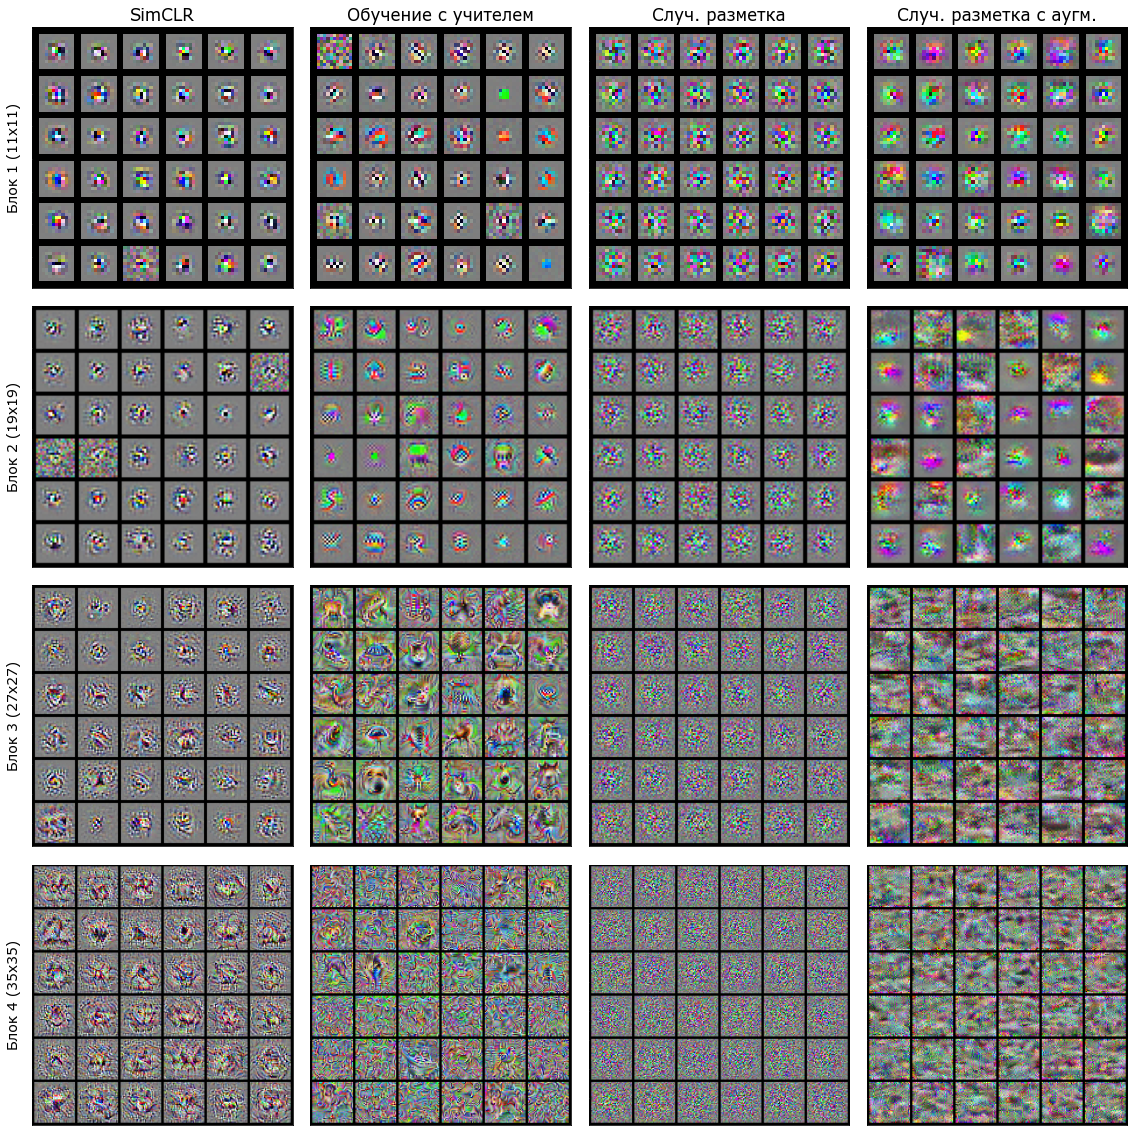

In [15]:
fig, axs = plt.subplots(4, 4, figsize=(16, 16), squeeze=True)

for i in range(4):
    axs[i, 0].imshow(make_grid(torch.sigmoid(renormalize(simclr_patches[i + 1])), nrow=6).permute(1, 2, 0))
    axs[i, 1].imshow(make_grid(torch.sigmoid(renormalize(supervised_patches[i + 1])), nrow=6).permute(1, 2, 0))
    axs[i, 2].imshow(make_grid(torch.sigmoid(renormalize(randy_patches[i + 1])), nrow=6).permute(1, 2, 0))
    axs[i, 3].imshow(make_grid(torch.sigmoid(renormalize(randy_aug_patches[i + 1])), nrow=6).permute(1, 2, 0))

for ax in axs.flatten():
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')

axs[0, 0].set_title('SimCLR')
axs[0, 1].set_title('Обучение с учителем')
axs[0, 2].set_title('Случ. разметка')
axs[0, 3].set_title('Случ. разметка с аугм.')

axs[0, 0].set_ylabel('Блок 1 (11x11)')
axs[1, 0].set_ylabel('Блок 2 (19x19)')
axs[2, 0].set_ylabel('Блок 3 (27x27)')
axs[3, 0].set_ylabel('Блок 4 (35x35)')

plt.tight_layout()
plt.savefig('plots/activations.pdf')
plt.show()